# 0.0 Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import pickle
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
import json

In [45]:
pd.options.mode.chained_assignment = None  # default='warn'

## 0.01 Helper Functions

In [46]:
# Apply custom format do DF
def custom_format(x):
    try:
        x = float(x)
        if x >= 1000:
            return f"{x:,.0f}"
        else:
            return f"{x:.2f}"
    except (ValueError, TypeError):
        return x

def apply_custom_format(df):
    return df.style.format({col: custom_format for col in df.columns if col != 'attributes'})

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.1 Loading Dataset

In [47]:
df_raw = pd.read_csv('../dataset/train.csv')
df1=df_raw.copy()

# 1.0 Data Description

In [48]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns= cols_new

## 1.1 Data Dimension

In [49]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.2 Data Types

In [50]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [51]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [52]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])


In [53]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.mode()[0])).T


# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'mode']
m_formmatted = apply_custom_format(m)
m_formmatted


,attributes,min,max,range,mean,median,std,skew,kurtosis,mode
0,id,1.00,"381,109","381,108","190,555","190,555","110,017",0.00,-1.20,1.00
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57,24.00
2,driving_license,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35,1.00
3,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87,28.00
4,previously_insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97,0.00
5,annual_premium,"2,630","540,165","537,535","30,564","31,669","17,213",1.77,34.00,"2,630"
6,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97,152.00
7,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20,256.00
8,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30,0.00


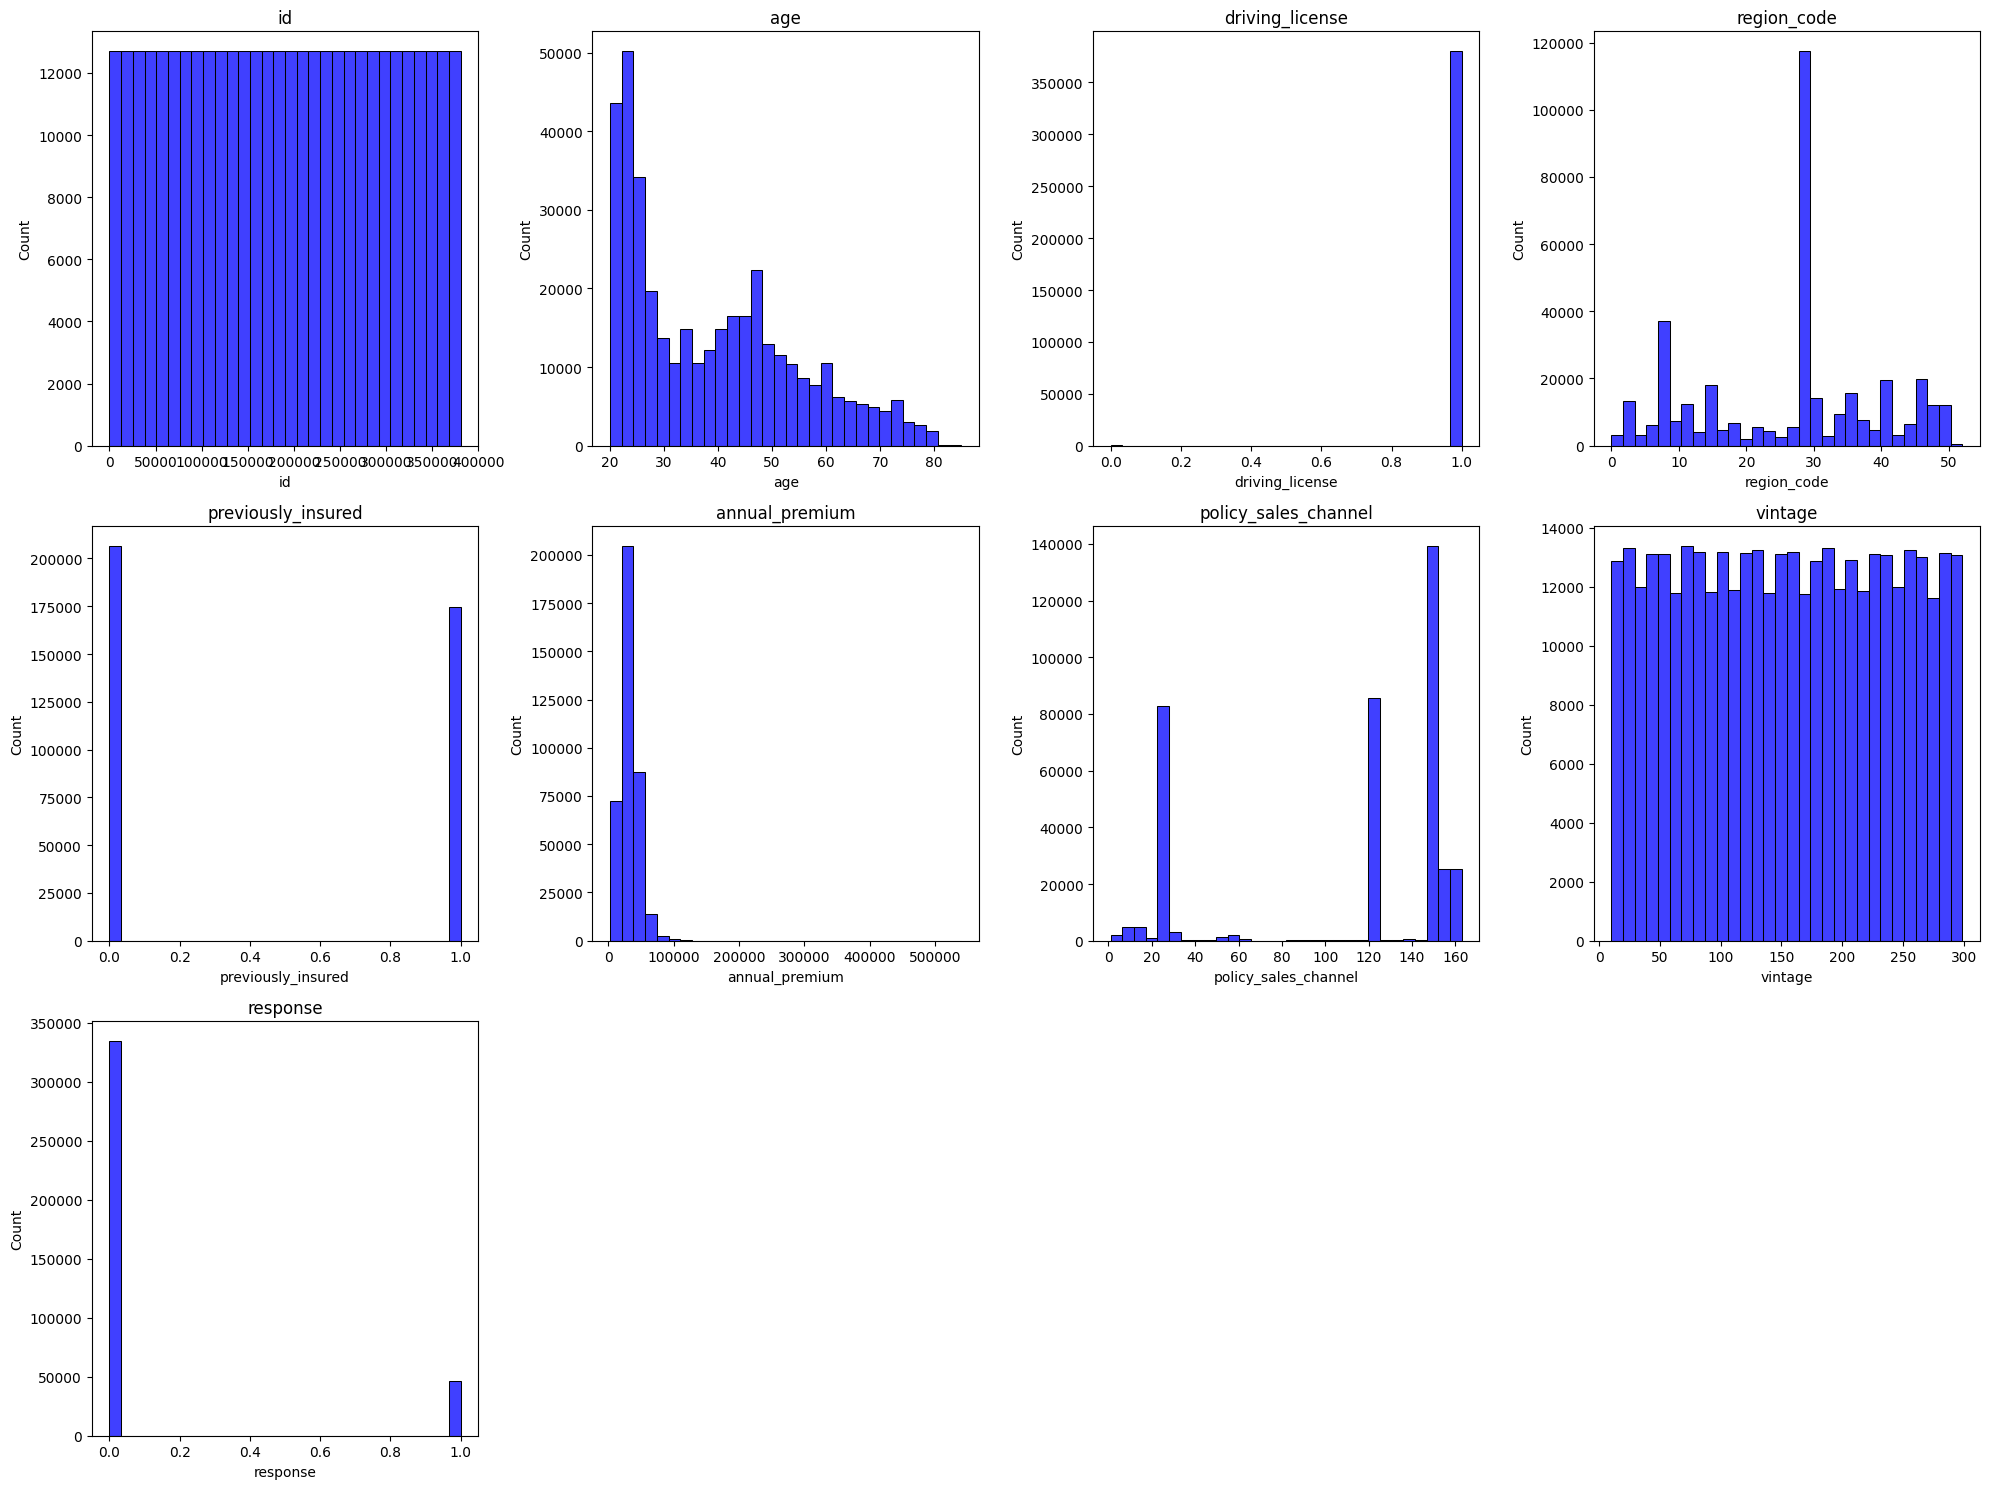

In [54]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 15))

for i, column in enumerate(num_attributes.columns, 1):  
    plt.subplot(len(num_attributes.columns) // 4 + 1, 4, i)
    sns.histplot(num_attributes[column], kde=False, bins=30, color='blue')
    # Add legend and title
    plt.title(column)

plt.tight_layout()
plt.show()

# 2.0 Feature Engineering

In [56]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )


# 3.0 Data Filtering

In [57]:
df3 = df2.copy()

# 4.0 EDA

In [58]:
df4 = df3.copy()

In [59]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


## 4.1 Bivariate Analysis

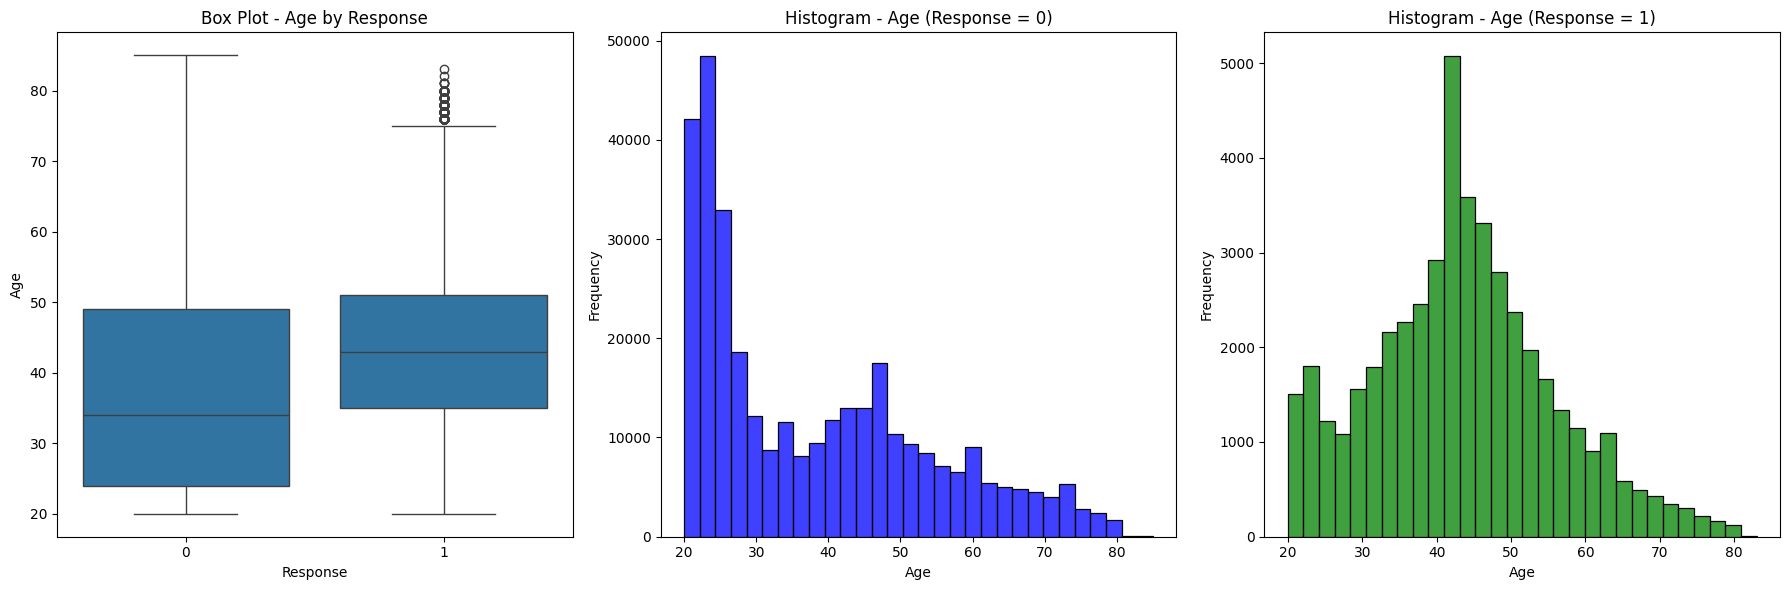

In [37]:
# Age

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x='response', y='age', data=df4, ax=axs[0])
axs[0].set_title('Box Plot - Age by Response')
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Age')

# Histogram - age for response == 0

aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00, bins=30, kde=False, color='blue', ax=axs[1])
axs[1].set_title('Histogram - Age (Response = 0)')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# Histogram - age for response == 1

aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux01, bins=30, kde=False, color='green', ax=axs[2])
axs[2].set_title('Histogram - Age (Response = 1)')
axs[2].set_xlabel('Age')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Findings:
# customers who purchased car insurance tend to be slightly older on average.
# This indicates that middle-aged customers are more likely to buy car insurance compared to younger customers.
# Age can possibly help predict whether a customer will buy car insurance or not.

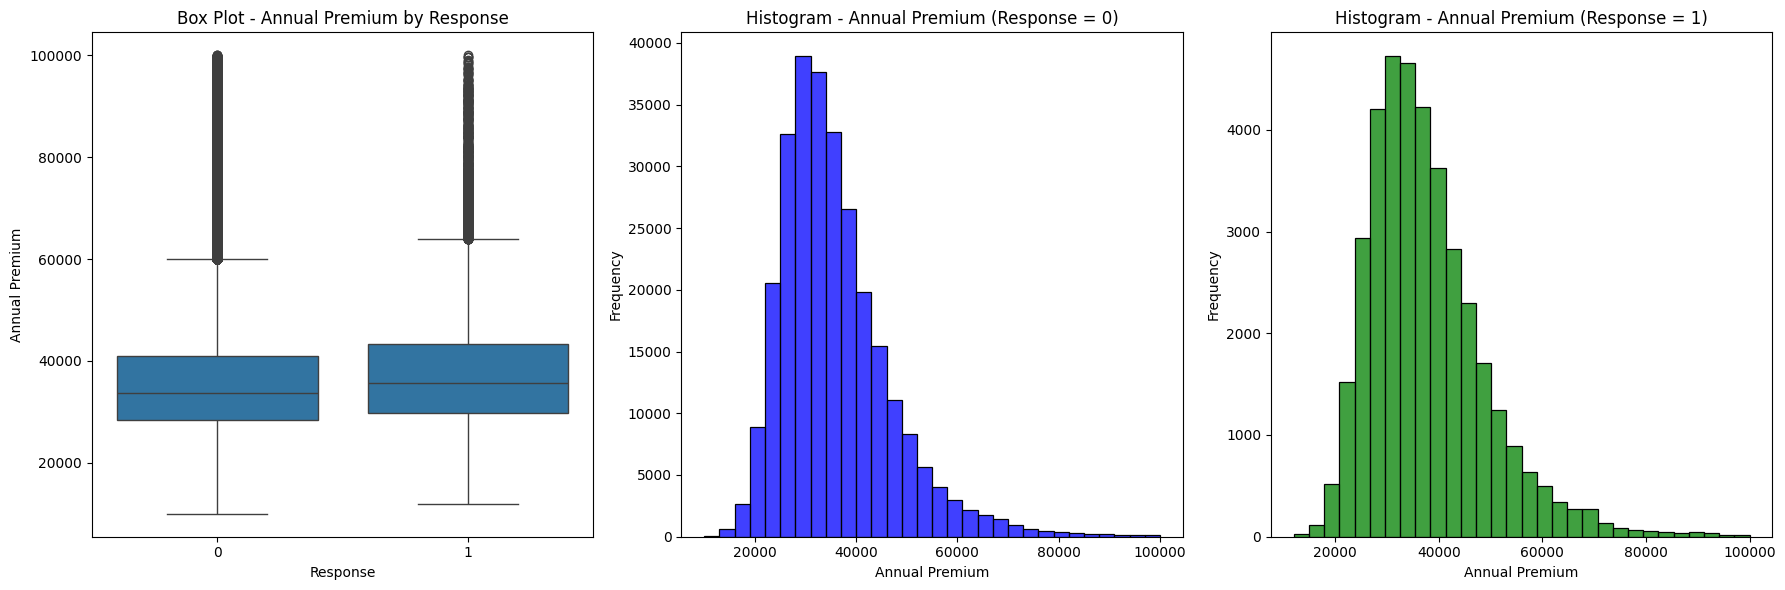

In [60]:
# annual_premium
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Box Plot - Annual Premium by Response
sns.boxplot(x='response', y='annual_premium', data=df4, ax=axs[0])
axs[0].set_title('Box Plot - Annual Premium by Response')
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Annual Premium')

# Histogram - Annual Premium for response == 0
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux00, bins=30, kde=False, color='blue', ax=axs[1])
axs[1].set_title('Histogram - Annual Premium (Response = 0)')
axs[1].set_xlabel('Annual Premium')
axs[1].set_ylabel('Frequency')

# Histogram - Annual Premium for response == 1
aux01 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux01, bins=30, kde=False, color='green', ax=axs[2])
axs[2].set_title('Histogram - Annual Premium (Response = 1)')
axs[2].set_xlabel('Annual Premium')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Findings: Both groups also have a significant number of outliers, indicating that there are some
# customers who pay much higher premiums than the majority.
# Those who buy car insurance tend to pay a bit more on average.
# Annual Premium cannot possible predict whether a customer will buy car insurance or not. They have similar distributions.

In [39]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = (aux['driving_license'] / aux['driving_license'].sum()) * 100
aux_formmatted = apply_custom_format(aux)
aux_formmatted

# Findings: more people with driver's license are not buying car insurance.
# Not determinant at this time the relevance of this feature regarding prediction.

,response,driving_license,driving_license_perc
0,0.00,"333,628",87.73
1,1.00,"46,669",12.27


<Axes: xlabel='response', ylabel='driving_license_perc'>

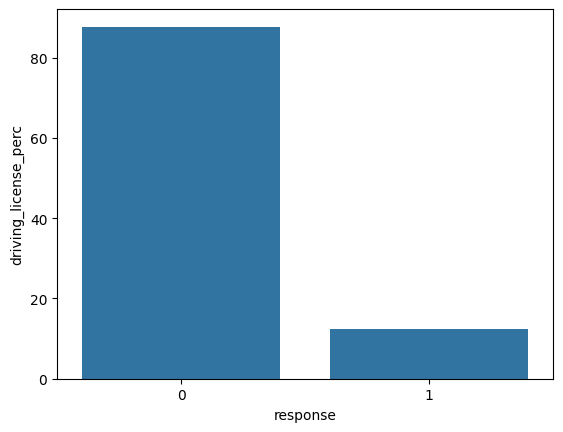

In [40]:
sns.barplot( x= 'response', y='driving_license_perc', data=aux)

<Axes: xlabel='region_code', ylabel='id'>

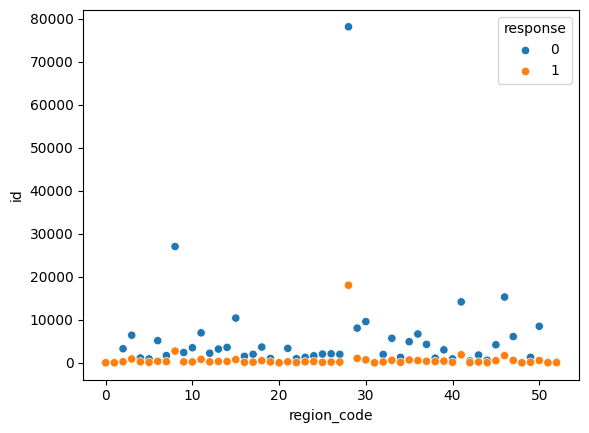

In [61]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

# Findings: even though region 28 has the highest number of people who bought car insurance, is not 
# possible to define as a good variable to predict if they will buy car insurance or not.
# all other regions have similar number of people who bought car insurance.

In [63]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
# Findings: no significant relation between previously insured and response
# most people who have insurance are not changing car insurance

response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


In [64]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().apply

<bound method DataFrame.apply of         vehicle_age  response  proportion
0      below_1_year         0    0.437031
1  between_1_2_year         0    0.413319
2  between_1_2_year         1    0.088816
3      over_2_years         0    0.028930
4      below_1_year         1    0.019001
5      over_2_years         1    0.012902>

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2


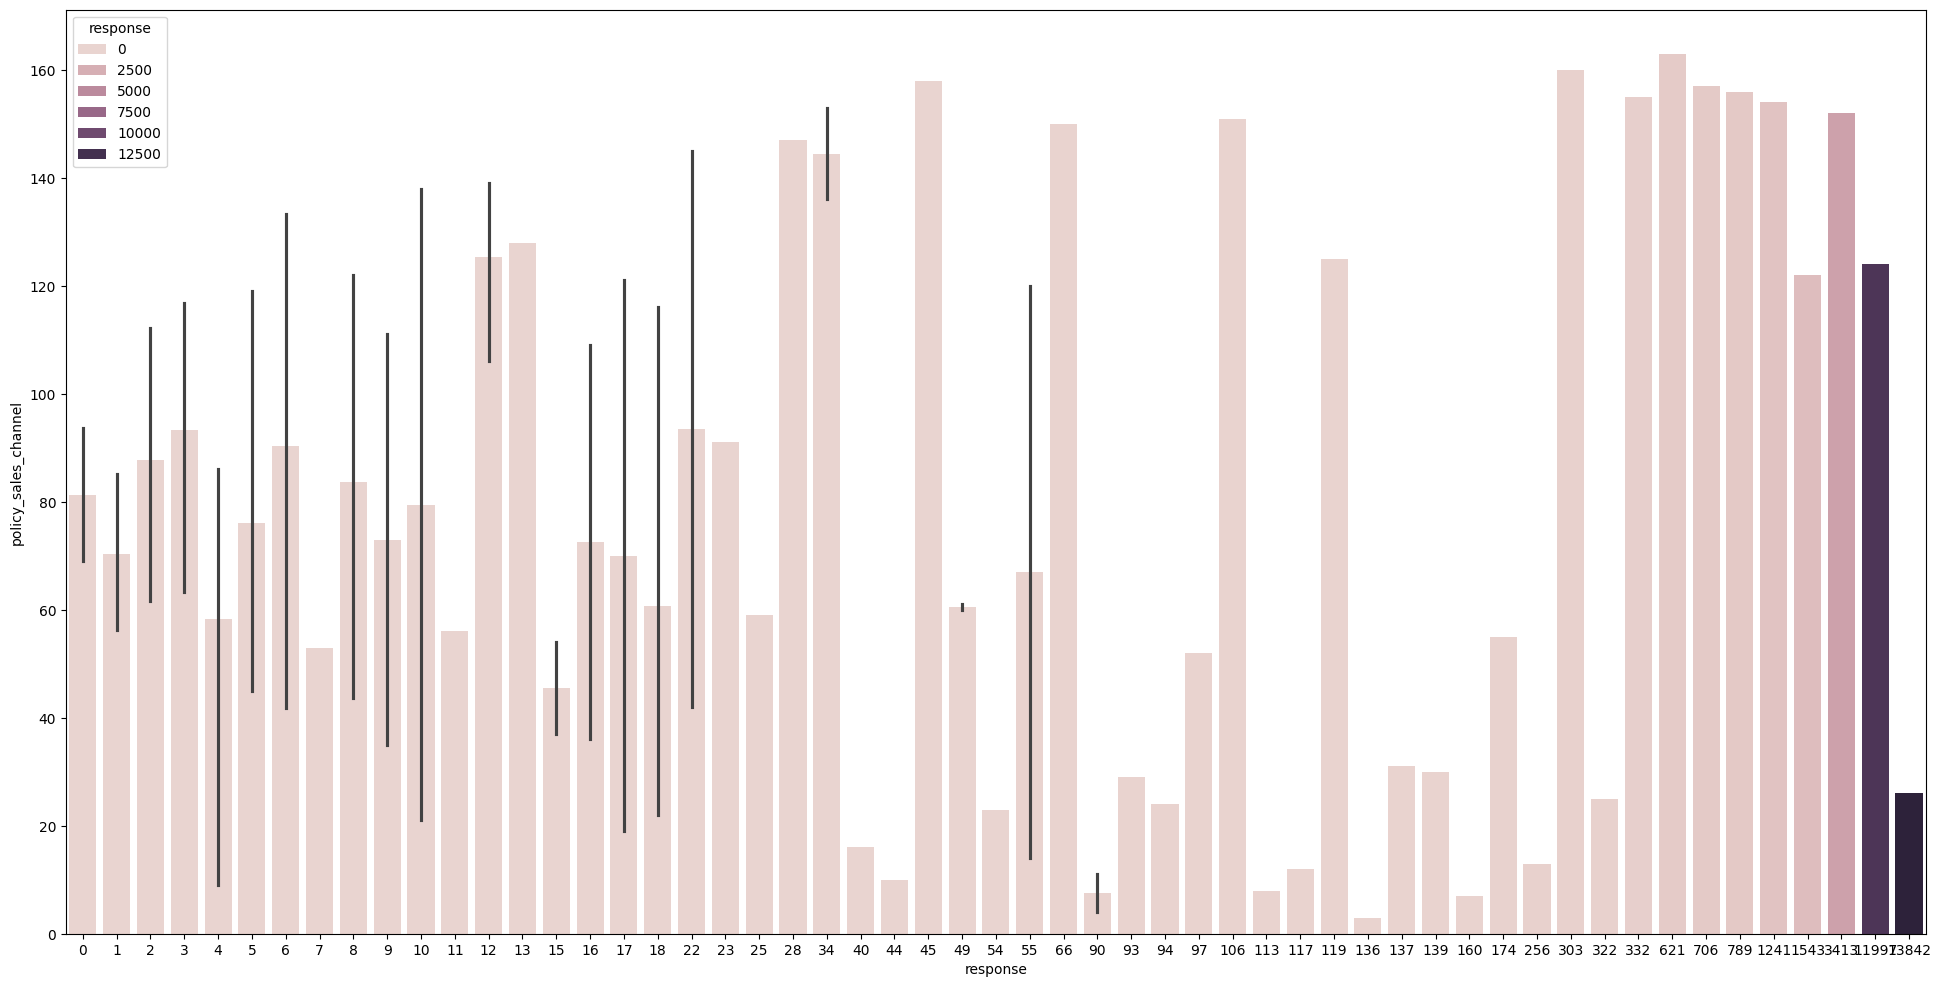

In [66]:
# policy_sales_channel
plt.figure(figsize= (24, 12))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x = 'response', y='policy_sales_channel', hue='response', data=aux)
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux.head()

<Axes: xlabel='vintage', ylabel='Count'>

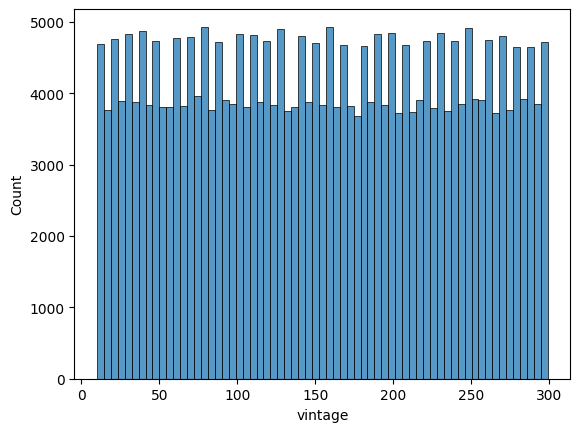

In [67]:
# vintage
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

<Axes: xlabel='vintage', ylabel='Count'>

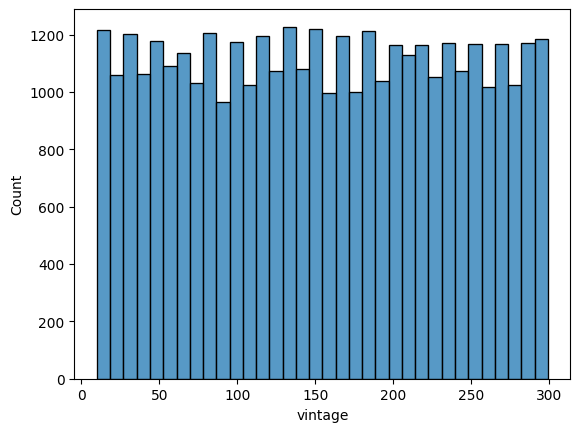

In [68]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

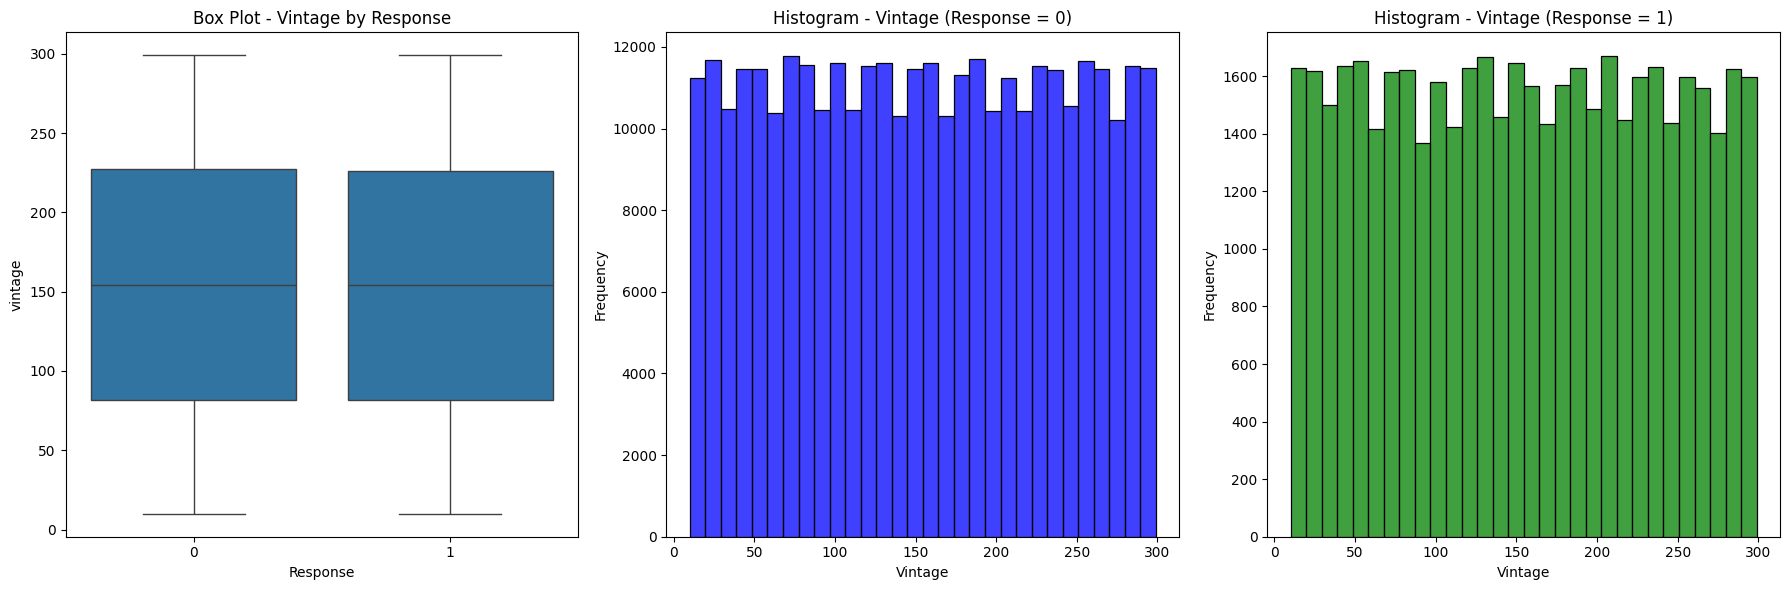

In [ ]:
# vintage
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Box Plot - Vintage by Response
sns.boxplot(x='response', y='vintage', data=df4, ax=axs[0])
axs[0].set_title('Box Plot - Vintage by Response')
axs[0].set_xlabel('Response')
axs[0].set_ylabel('vintage')

# Histogram - Annual Premium for response == 0
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00, bins=30, kde=False, color='blue', ax=axs[1])
axs[1].set_title('Histogram - Vintage (Response = 0)')
axs[1].set_xlabel('Vintage')
axs[1].set_ylabel('Frequency')

# Histogram - Annual Premium for response == 1
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux01, bins=30, kde=False, color='green', ax=axs[2])
axs[2].set_title('Histogram - Vintage (Response = 1)')
axs[2].set_xlabel('Vintage')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#  Findings: no distinctive relation between vintage and responses.

# 5.0 Data Preparation

In [85]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [86]:
ss=pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump( ss, open('../features/annual_premium_scaler.pkl', 'wb') )

## 5.2 Rescaling

In [87]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open('../features/age_scaler.pkl', 'wb') )
# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values).astype(float)
pickle.dump( mms_vintage, open('../features/vintage_scaler.pkl', 'wb') )

## 5.3 Encoder

In [88]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump( target_encode_gender, open('../features/target_encode_gender.pkl', 'wb') )

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump( target_encode_region_code, open('../features/target_encode_region_code.pkl', 'wb') )

# vehicle_age - One Hot Encoding
# target_encode_vehicle_age = df5.groupby('vehicle_age')['response'].mean()
# df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map(target_encode_vehicle_age).astype(float)
# pickle.dump( target_encode_vehicle_age, open('../features/target_vehicle_age.pkl', 'wb') )
df5 = pd.get_dummies(df5, prefix=['vehicle_age'], columns=['vehicle_age'])

# policel_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:,'policy_sales_channel'] = df5[ 'policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump( fe_policy_sales_channel, open('../features/fe_policy_sales_channel.pkl', 'wb') )

## 5.4 Validation Preparation   

In [89]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
# x_validation['age'] = x_validation['age'].astype(float)
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
# x_validation['region_code'] = x_validation['region_code'].astype(float)
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )
# x_validation.loc[:, 'vehicle_age'] =  x_validation.loc[:, 'vehicle_age'].map( target_encode_vehicle_age )

# annual_premium
# x_validation['annual_premium'] = x_validation['annual_premium'].astype(float)
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
# x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].astype(float)
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
# x_validation['vintage'] = x_validation['vintage'].astype(float)
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

/tmp/ipykernel_3039/1938637907.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21538462 0.06153846 0.04615385 ... 0.43076923 0.07692308 0.06153846]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )
/tmp/ipykernel_3039/1938637907.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.66089965 0.57439446 0.29757785 ... 0.89965398 0.17647059 0.82698962]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )


In [90]:
x_validation = x_validation.fillna(0).infer_objects(copy=False)
x_validation.isna().sum()

/tmp/ipykernel_3039/2192500289.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_validation = x_validation.fillna(0).infer_objects(copy=False)


id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

In [92]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
188452,188453,0.138297,0.000000,1,0.117847,1,0,-0.274505,0.051359,0.010381,0,True,False,False
34421,34422,0.100366,0.107692,1,0.066494,1,0,0.199317,0.386117,0.176471,0,True,False,False
175839,175840,0.100366,0.030769,1,0.082267,1,0,-0.079558,0.386117,0.557093,0,True,False,False
321252,321253,0.138297,0.138462,1,0.054608,1,0,-0.371569,0.386117,0.813149,0,True,False,False
83527,83528,0.138297,0.076923,1,0.111844,1,0,0.838895,0.386117,0.352941,0,True,False,False


# 6.0 Feature Selection

## 6.1 Features Importance

In [93]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                annual_premium    0.272761
0                       vintage    0.247893
0                           age    0.158400
0                   region_code    0.101474
0                vehicle_damage    0.071459
0            previously_insured    0.058717
0          policy_sales_channel    0.058438
0      vehicle_age_below_1_year    0.015529
0  vehicle_age_between_1_2_year    0.006807
0                        gender    0.004880
0      vehicle_age_over_2_years    0.003133
0               driving_license    0.000510


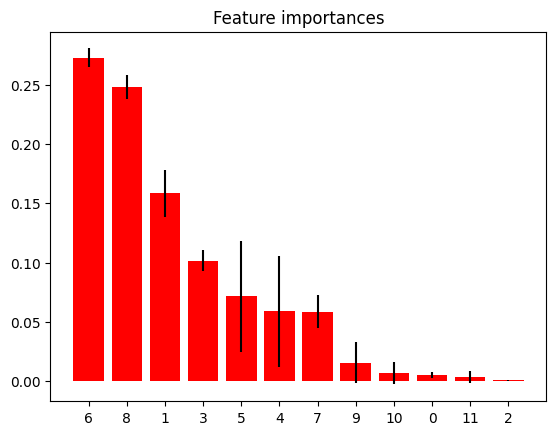

In [94]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim(-1, x_train_n.shape[1])
plt.show()


# 7.0 Machine Learning

In [95]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                'policy_sales_channel']


In [96]:
x_train = df5 [cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1 KNN Classifier

In [97]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - generalization power (validate dataset)
yhat_knn = knn_model.predict_proba(x_val)


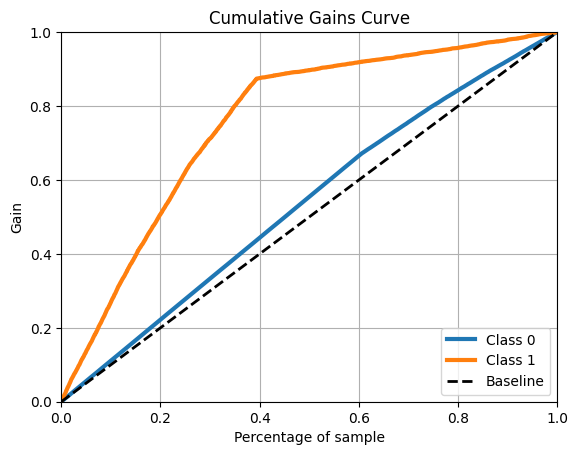

In [98]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);


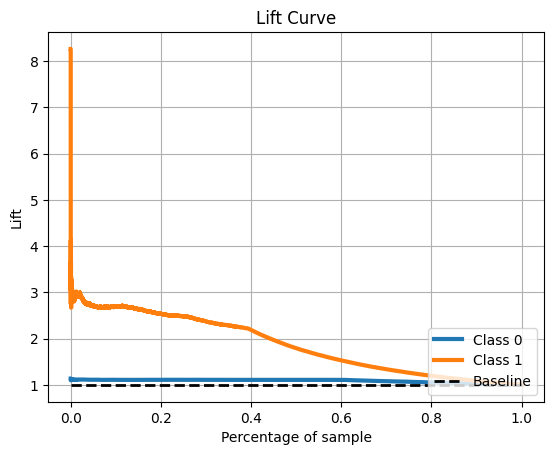

In [99]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2 Logistic Regression

In [100]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)



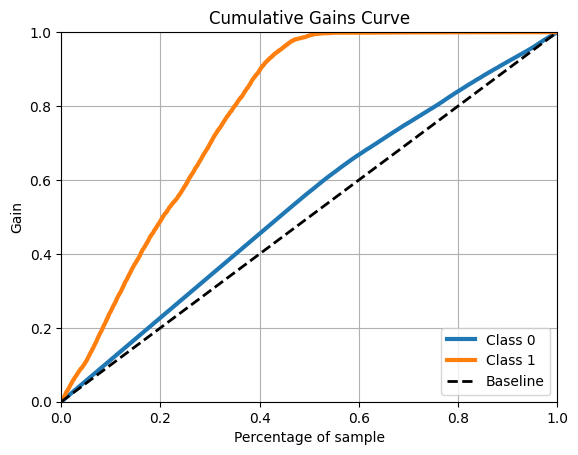

In [102]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);


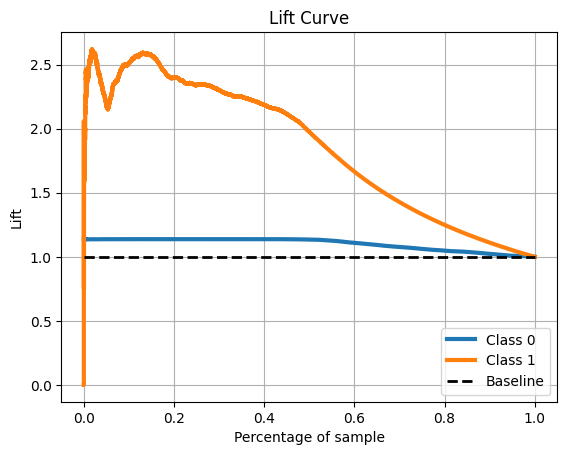

In [ ]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3 Extra Trees Classifier

In [103]:
# Model definition
et = en.ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1)

# Model fit
et.fit(x_train, y_train)

# Model predict (probability)
yhat_et = et.predict_proba(x_val)


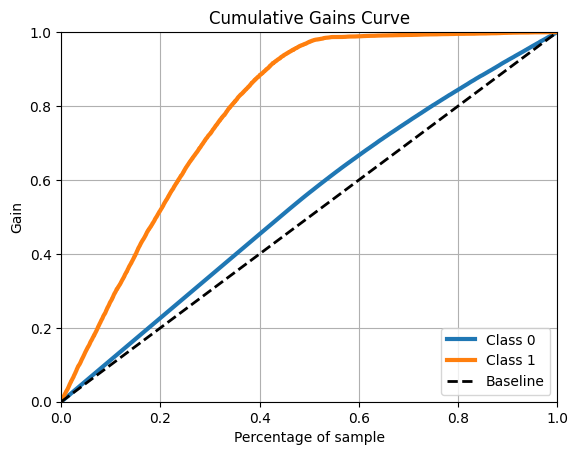

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

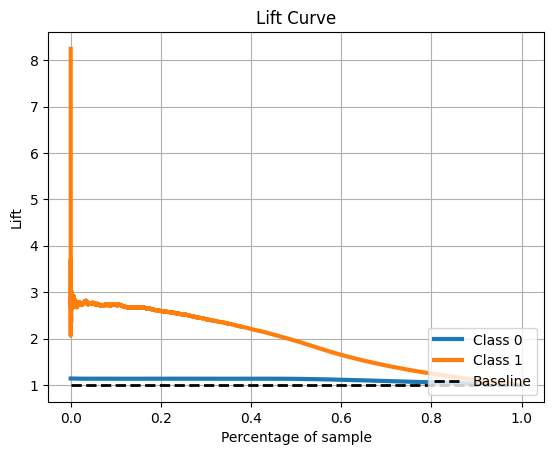

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 7.4 Random Forest

In [ ]:
# model definition
rf = en.RandomForestClassifier( n_estimators=300, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

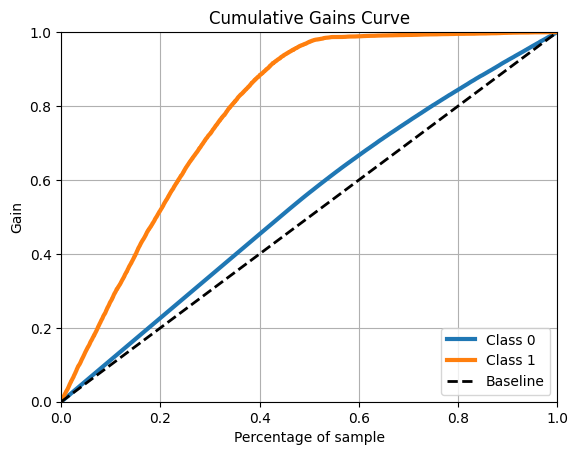

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

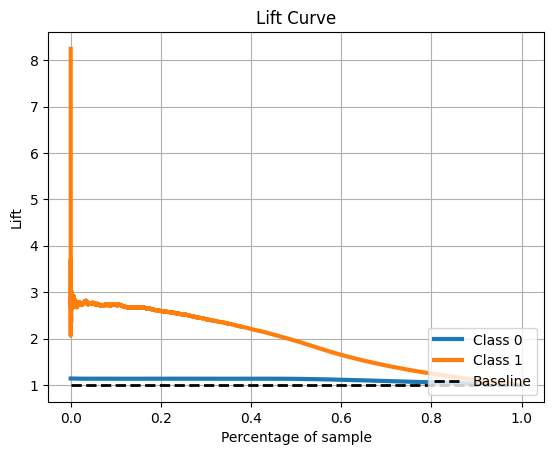

In [ ]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

# 8.0 Model Metrics

In [105]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

In [106]:
def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [107]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df8, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=15 )

In [108]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
                    [0.3, 0.4, 0.2],  # 1 is in top 2
                    [0.2, 0.4, 0.3],  # 2 is in top 2
                    [0.7, 0.2, 0.1]]) # 2 isn't in top 2

top_k_accuracy_score(y_true, y_score, k=2)

0.75

In [109]:
y_true = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

## 8.1 Cummulative Curve Manually

<Axes: xlabel='base_cum_perc', ylabel='real_cum_perc'>

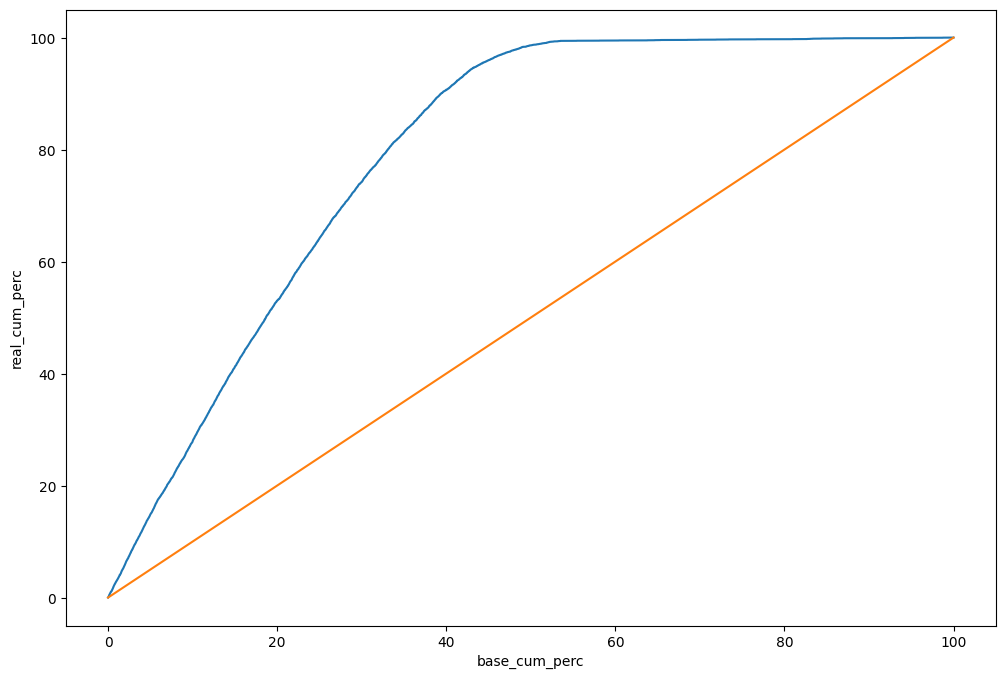

In [110]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## 8.2 Cummulative Curve Manually

<Axes: xlabel='base_cum_perc', ylabel='lift'>

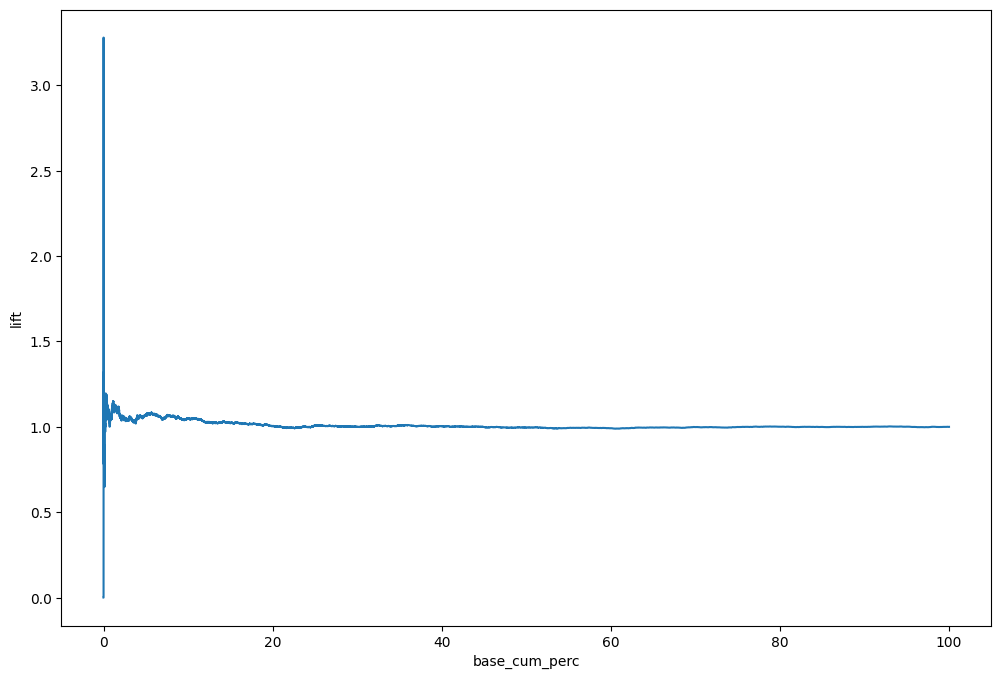

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

## 8.3 ROI Curve Manually

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve


#plt.figure( figsize=(12,8))
#sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [ ]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,0.9,153,5508.0,3.6,1.000000,5504.4
8,0.80,0.8,268,8576.0,3.2,0.800000,8572.8
7,0.70,0.7,567,15876.0,2.8,0.622222,15873.2
6,0.60,0.6,1119,26856.0,2.4,0.466667,26853.6
5,0.50,0.5,1997,39940.0,2.0,0.333333,39938.0
4,0.40,0.4,3505,56080.0,1.6,0.222222,56078.4
3,0.30,0.3,5171,62052.0,1.2,0.133333,62050.8
2,0.20,0.2,7017,56136.0,0.8,0.066667,56135.2
1,0.10,0.1,8315,33260.0,0.4,0.022222,33259.6
0,0.01,0.0,48110,0.0,0.0,0.000000,0.0


<Axes: xlabel='base', ylabel='revenue'>

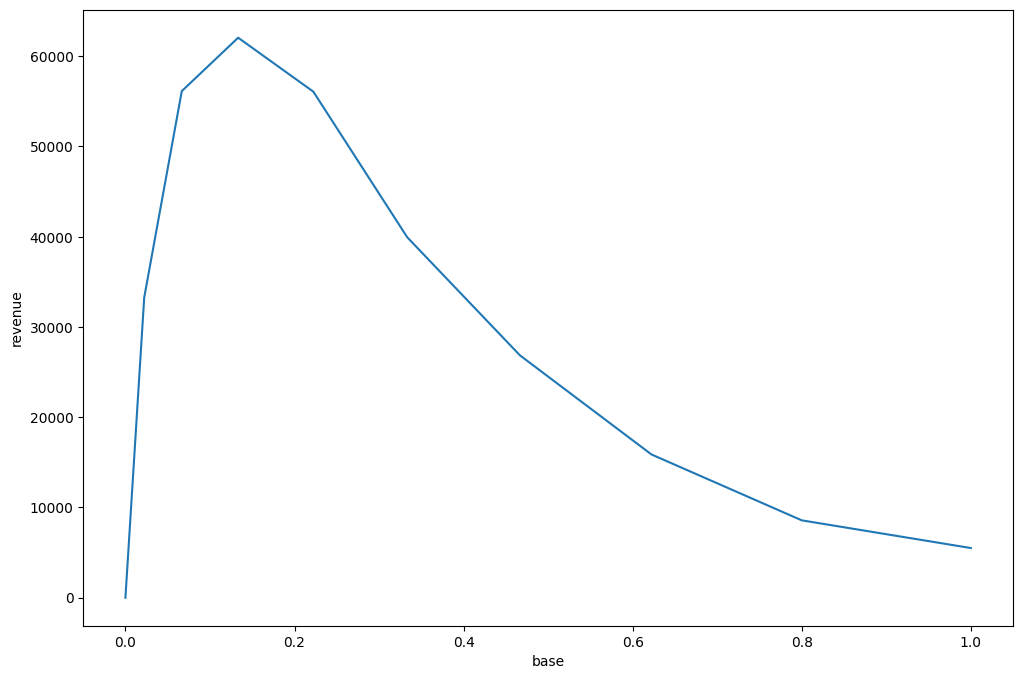

In [ ]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

# 9.0 Deploy to Production

In [114]:
pickle.dump (lr_model, open ('../models/model_health_insurance.pkl', 'wb'))

## 9.1 Helth Insurance Class

In [120]:
import pickle
import pandas as pd
import numpy as np
import os
import json

class HealthInsurance:
    def __init__(self):
        self.home_path = ''
        self.annual_premium_scaler     = pickle.load(open('features/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler                = pickle.load(open('features/age_scaler.pkl', 'rb'))
        self.vintage_scaler            = pickle.load(open('features/vintage_scaler.pkl', 'rb'))
        self.target_encode_gender      = pickle.load(open('features/target_encode_gender.pkl', 'rb'))
        self.target_encode_region_code = pickle.load(open('features/target_encode_region_code.pkl', 'rb'))
        self.fe_policy_sales_channel   = pickle.load(open('features/fe_policy_sales_channel.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        ## 1.0 Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
        df1.columns = cols_new
        return df1
        
    def feature_engineering(self, df2):
        ## 2.0 Feature Engineering
        # vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        # vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        
        return df2
    
    def data_preparation(df5):
        # 3.0 Preprocessing
        # Annual Premium - Standard Scaler
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
    
        return df5 [cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )
    

## 9.2 API Handler

In [125]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from health_insurance.healthinsurance import HealthInsurance



# loading model
path= '../models/'
model = pickle.load(open('models/model_health_insurance.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/heathinsurance/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype = 'application/json')
    
# Run flask app    
if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    # app.run('0.0.0.0', port=5000, debug=True)
    # app.run( '0.0.0.0', debug=True )
    # port = os.environ.get('PORT', 5000)
    app.run(host = '0.0.0.0', port=port)

ModuleNotFoundError: No module named 'health_insurance'

## 9.3 API Tester

In [126]:
import requests

In [127]:
#loading test dataset
df_test = x_validation
df_test[ 'response'] = y_validation
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response
61843,61844,0.100366,0.215385,1,0.066494,1,0,0.580728,0.010457,0.660900,False,True,False,0
219987,219988,0.100366,0.061538,1,0.104550,1,0,-0.518623,0.386117,0.574394,True,False,False,0
158110,158111,0.100366,0.046154,1,0.054608,1,0,-0.654457,0.386117,0.297578,True,False,False,0
114799,114800,0.138297,0.076923,1,0.187822,1,0,2.782078,0.386117,0.664360,True,False,False,0
221724,221725,0.100366,0.061538,1,0.086380,0,1,-1.707467,0.386117,0.692042,True,False,False,0


In [ ]:
df_test = df_test.sample(10)
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
309047,309048,0.104091,0.076923,1,0.087269,0,0,0.173882,0.353380,0.429066,0
36168,36169,0.104091,0.184615,1,0.070010,0,1,-1.623109,0.028053,0.280277,0
54303,54304,0.104091,0.430769,1,0.125710,0,1,0.137028,0.193672,0.837370,1
331371,331372,0.104091,0.430769,1,0.085555,0,1,-1.623109,0.193672,0.615917,0
181136,181137,0.138507,0.261538,1,0.086259,0,1,-0.075083,0.209540,0.826990,0
26240,26241,0.138507,0.307692,1,0.187882,0,1,0.258517,0.193672,0.785467,0
279228,279229,0.138507,0.169231,1,0.187882,1,1,0.518003,0.353380,0.425606,0
67242,67243,0.104091,0.076923,1,0.112670,1,1,-0.300390,0.353380,0.809689,0
201994,201995,0.104091,0.138462,1,0.072054,1,0,-0.136584,0.353380,0.235294,0
365710,365711,0.104091,0.292308,1,0.121676,0,1,-0.256387,0.028053,0.432526,1


In [ ]:
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
data

'[{"id": 309048, "gender": 0.10409145177548847, "age": 0.07692307692307693, "driving_license": 1, "region_code": 0.08726945569050833, "previously_insured": 0, "vehicle_damage": 0, "annual_premium": 0.17388166881341166, "policy_sales_channel": 0.35338010476012427, "vintage": 0.4290657439446367, "response": 0}, {"id": 36169, "gender": 0.10409145177548847, "age": 0.18461538461538463, "driving_license": 1, "region_code": 0.0700100300902708, "previously_insured": 0, "vehicle_damage": 1, "annual_premium": -1.62310852427616, "policy_sales_channel": 0.02805301636343957, "vintage": 0.2802768166089965, "response": 0}, {"id": 54304, "gender": 0.10409145177548847, "age": 0.4307692307692308, "driving_license": 1, "region_code": 0.12571041948579162, "previously_insured": 0, "vehicle_damage": 1, "annual_premium": 0.13702808201070776, "policy_sales_channel": 0.1936717537973085, "vintage": 0.8373702422145329, "response": 1}, {"id": 331372, "gender": 0.10409145177548847, "age": 0.4307692307692308, "driv

In [ ]:
# API Call 
#url= 'http://0.0.0.0:5000/HealthInsurance/predict'
url= 'https://health-insurance-cross-sell-z284.onrender.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers = header)
print('Status Code {}'.format(r.status_code))


Status Code 500


In [ ]:
d1 = pd.DataFrame (r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)